In [2]:
!pip install chaospy
!pip install casadi

     |████████████████████████████████| 34.2 MB 17 kB/s 


In [49]:
import chaospy
import numpy as np
import casadi as ca
from matplotlib import pyplot

In [48]:
import scipy.integrate as integrate


Exploring gPC

example system: $\frac{d x(t)}{d t}=-\theta x(t)+w(t), x(0)=1$, where $\theta \sim \mathcal{N}(0,1)$ and $w(t) \sim \mathcal{N}(0,1)$

From the paper "An efficient method for stochastic optimal control with joint chance constraints for nonlinear systems" 

In [115]:
coordinates = np.linspace(0, 1, 1000)

In [116]:
def model_mu(theta):
    return np.e**(-theta * coordinates)

In [117]:
def model_V(theta):
    return (1 - np.e**(-2 * theta * coordinates))/(2*theta)

In [118]:
# mu_t = lambda t: np.exp(t**2/2)
# sigma_int = lambda t,theta: (1-np.exp(-2*theta*t)/(2*theta))*np.exp(-theta**2/2)

# result = integrate.quad(sigma_int(2), 0, 4.5) 

In [119]:
# result = integrate.quad(lambda x:x**2, 0, 1)

Pseudo-spectral projection: [reference](https://chaospy.readthedocs.io/en/master/user_guide/main_usage/pseudo_spectral_projection.html)

In [132]:
normal = chaospy.Normal(0, 1)

In [158]:
gauss_quads = [
    chaospy.generate_quadrature(order, normal, rule="gaussian")
    for order in range(1, 6)
]

In [159]:
gauss_evals = [
    np.array([model_mu(node) for node in nodes.T])
    for nodes, weights in gauss_quads
]

In [160]:
nodes

array([[-3.32425743, -1.88917588, -0.61670659,  0.61670659,  1.88917588,
         3.32425743]])

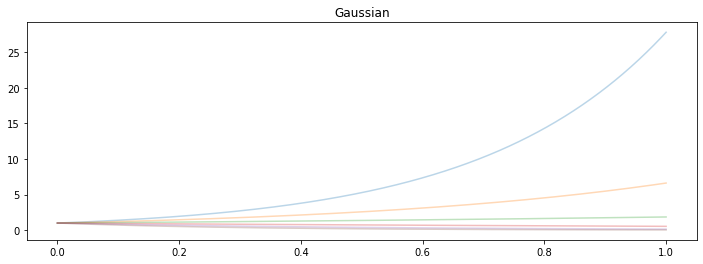

In [168]:
pyplot.subplot(111)
pyplot.plot(coordinates, gauss_evals[4].T, alpha=0.3)
pyplot.title("Gaussian")

pyplot.show()

In [169]:
expansions = [chaospy.generate_expansion(order, normal)
              for order in range(1, 10)]
expansions[0].round(10)

polynomial([1.0, q0])

In [170]:
coordinates = np.linspace(0, 1, 1000)

In [171]:
gauss_model_approx = [
    chaospy.fit_quadrature(expansion, nodes, weights, evals)
    for expansion, (nodes, weights), evals in zip(expansions, gauss_quads, gauss_evals)
]

In [186]:
gauss_model_approx[0].shape

(1000,)

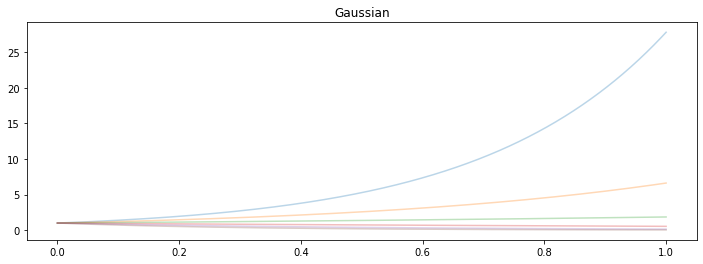

In [172]:
model_approx = gauss_model_approx[4]
nodes, _ = gauss_quads[4]
evals = model_approx(*nodes)

pyplot.subplot(111)
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Gaussian")

pyplot.show()

In [173]:
expected = chaospy.E(gauss_model_approx[-2], normal)
std = chaospy.Std(gauss_model_approx[-2], normal)

In [174]:
expected[:4].round(4), std[:4].round(4)

(array([1., 1., 1., 1.]), array([0.   , 0.001, 0.002, 0.003]))

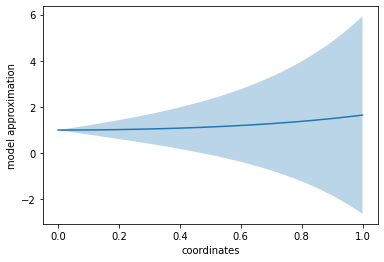

In [175]:
pyplot.rc("figure", figsize=[6, 4])

pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
pyplot.fill_between(
    coordinates, expected-2*std, expected+2*std, alpha=0.3)
pyplot.plot(coordinates, expected)

pyplot.show()

In [176]:
_t = coordinates

true_mean = np.hstack([
    np.e**(_t**2/2)])

In [177]:
def error_in_mean(predicted_mean, true_mean=true_mean):
    return np.mean(np.abs(predicted_mean-true_mean))

In [178]:
error_in_mean(expected)

3.6874133500355288e-06

In [179]:
gauss_sizes = [len(weights) for _, weights in gauss_quads]
eps_gauss_mean = [
    error_in_mean(chaospy.E(model, normal))
    for model in gauss_model_approx
]

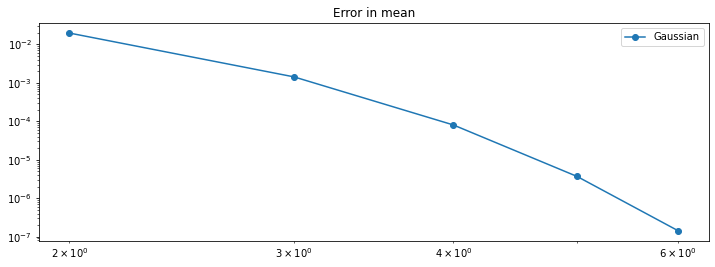

In [180]:
pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(111)
pyplot.title("Error in mean")
pyplot.loglog(gauss_sizes, eps_gauss_mean, "o-", label="Gaussian")
pyplot.legend()

Point collocation: [reference](https://chaospy.readthedocs.io/en/master/user_guide/main_usage/point_collocation.html)

In [187]:
gauss_nodes = [nodes for nodes, _ in gauss_quads]

In [189]:
sobol_samples = normal.sample(10000, rule="sobol")

In [193]:
sobol_nodes = [sobol_samples[:nodes.shape[1]] for nodes in gauss_nodes]

In [204]:
sobol_evals = [
    np.array([model_mu(node) for node in nodes.T])
    for nodes in sobol_nodes
]

Text(0.5, 1.0, 'Sobol evaluations')

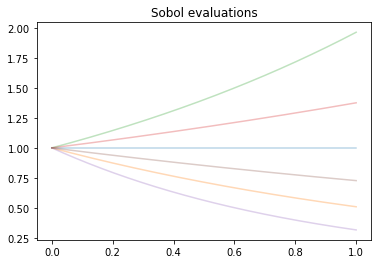

In [205]:
pyplot.subplot(111)
pyplot.plot(coordinates, sobol_evals[4].T, alpha=0.3)
pyplot.title("Sobol evaluations")


In [195]:
expansions = [chaospy.generate_expansion(order, normal)
              for order in range(1, 10)]
expansions[0].round(10)

polynomial([1.0, q0])

In [196]:
gauss_model_approx = [
    chaospy.fit_regression(expansion, samples, evals)
    for expansion, samples, evals in zip(expansions, gauss_nodes, gauss_evals)
]

In [206]:
sobol_model_approx = [
    chaospy.fit_regression(expansion, samples, evals)
    for expansion, samples, evals in zip(expansions, sobol_nodes, sobol_evals)
]

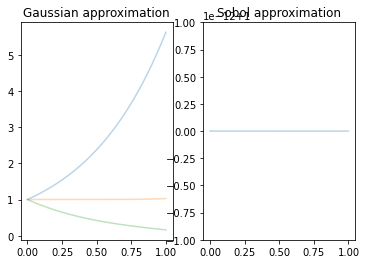

In [207]:
pyplot.subplot(121)
model_approx = gauss_model_approx[4]
evals = model_approx(*gauss_nodes[1])
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Gaussian approximation")

pyplot.subplot(122)
model_approx = sobol_model_approx[1]
evals = model_approx(*sobol_nodes[1])
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Sobol approximation")

pyplot.show()

In [199]:
expected = chaospy.E(gauss_model_approx[-2], normal)

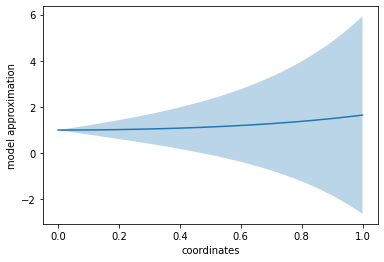

In [200]:
pyplot.rc("figure", figsize=[6, 4])

pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
pyplot.fill_between(
    coordinates, expected-2*std, expected+2*std, alpha=0.3)
pyplot.plot(coordinates, expected)

pyplot.show()

In [208]:
eps_sobol_mean = [
    error_in_mean(chaospy.E(model, normal))
    for model in sobol_model_approx
]

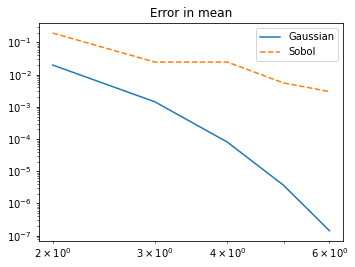

In [211]:
sizes = [nodes.shape[1] for nodes in gauss_nodes]

pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(121)
pyplot.title("Error in mean")
pyplot.loglog(sizes, eps_gauss_mean, "-", label="Gaussian")
pyplot.loglog(sizes, eps_sobol_mean, "--", label="Sobol")
pyplot.legend()